In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from keras.layers import LSTM

In [2]:
df = pd.read_csv("./datasets XMR/raw/XMR.csv")
df.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(['Date'], drop=True)
df.head(5)

,Close
Date,
2015-01-30,0.30
2015-01-31,0.29
2015-02-01,0.29
2015-02-02,0.30
2015-02-03,0.33


<AxesSubplot:xlabel='Date'>

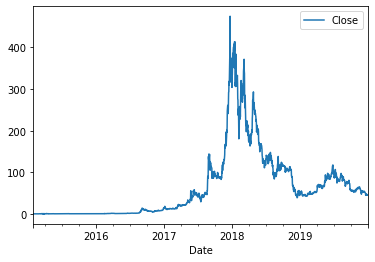

In [3]:
df =  df[['Close']]
df.plot(y='Close')

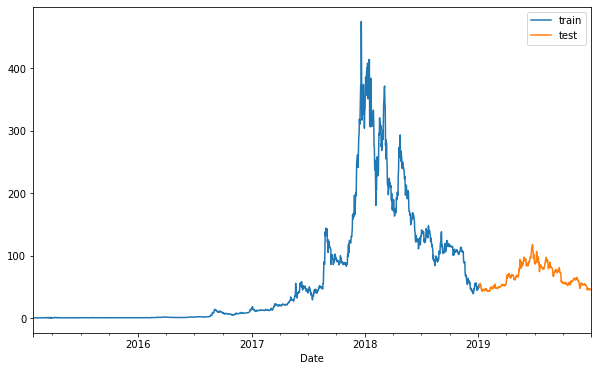

In [4]:
split_date = pd.Timestamp('2019/1/3')
train = df.loc[:split_date]
test = df.loc[split_date:]
ax = train.plot(figsize=(10,6))
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

In [5]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

train_max=max(train['Close'])
train_min=min(train['Close'])

test_max=max(test['Close'])
test_min=min(test['Close'])


# print(train_max)
# print(train_min)

print(test_max)
print(test_min)

train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)



X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

117.8
42.81


In [6]:
print('Train size: (%d x %d)'%(X_train.shape[0], X_train.shape[1]))
print('Test size: (%d x %d)'%(X_test.shape[0], X_test.shape[1]))

Train size: (1434 x 1)
Test size: (361 x 1)


In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K

In [8]:
from keras import metrics
K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='tanh', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error', metrics=[metrics.mae, metrics.categorical_accuracy])
model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=1)

Epoch 1/100
90/90 [==============================] - 0s 541us/step - loss: 0.0311 - mean_absolute_error: 0.1067 - categorical_accuracy: 1.0000
Epoch 2/100
90/90 [==============================] - 0s 538us/step - loss: 0.0221 - mean_absolute_error: 0.1068 - categorical_accuracy: 1.0000
Epoch 3/100
90/90 [==============================] - 0s 521us/step - loss: 0.0186 - mean_absolute_error: 0.1040 - categorical_accuracy: 1.0000
Epoch 4/100
90/90 [==============================] - 0s 510us/step - loss: 0.0160 - mean_absolute_error: 0.0971 - categorical_accuracy: 1.0000
Epoch 5/100
90/90 [==============================] - 0s 543us/step - loss: 0.0136 - mean_absolute_error: 0.0891 - categorical_accuracy: 1.0000
Epoch 6/100
90/90 [==============================] - 0s 587us/step - loss: 0.0115 - mean_absolute_error: 0.0814 - categorical_accuracy: 1.0000
Epoch 7/100
90/90 [==============================] - 0s 552us/step - loss: 0.0097 - mean_absolute_error: 0.0743 - categorical_accuracy: 1.0000

Epoch 57/100
90/90 [==============================] - 0s 586us/step - loss: 5.5400e-04 - mean_absolute_error: 0.0128 - categorical_accuracy: 1.0000
Epoch 58/100
90/90 [==============================] - ETA: 0s - loss: 7.7960e-04 - mean_absolute_error: 0.0165 - categorical_accuracy: 1.00 - 0s 555us/step - loss: 5.5435e-04 - mean_absolute_error: 0.0128 - categorical_accuracy: 1.0000
Epoch 59/100
90/90 [==============================] - 0s 584us/step - loss: 5.5630e-04 - mean_absolute_error: 0.0127 - categorical_accuracy: 1.0000
Epoch 60/100
90/90 [==============================] - 0s 609us/step - loss: 5.5533e-04 - mean_absolute_error: 0.0129 - categorical_accuracy: 1.0000
Epoch 61/100
90/90 [==============================] - 0s 528us/step - loss: 5.5397e-04 - mean_absolute_error: 0.0128 - categorical_accuracy: 1.0000
Epoch 62/100
90/90 [==============================] - 0s 527us/step - loss: 5.5518e-04 - mean_absolute_error: 0.0128 - categorical_accuracy: 1.0000
Epoch 63/100
90/90 [====

R-Squared: 0.843660


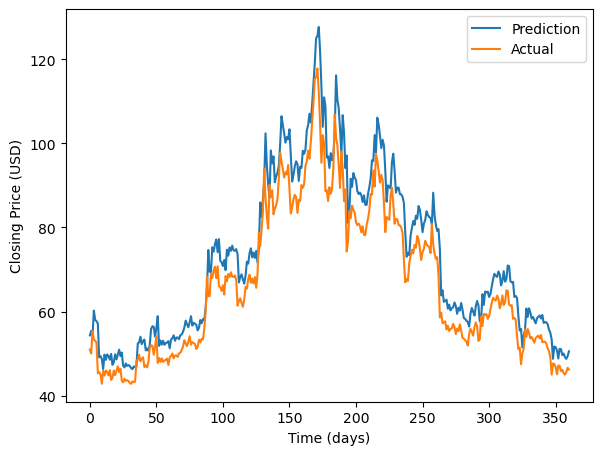

In [9]:
y_pred = model.predict(X_test)
plt.figure(figsize=(6.8,5.2),dpi=100)
plt.plot(y_pred* (train_max - train_min) + train_min, label='Prediction')
plt.plot(y_test* (train_max - train_min) + train_min, label='Actual')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Closing Price (USD)')
print('R-Squared: %f'%(r2_score(y_test, y_pred)))